# Clustering
Clustering is a family of unsupervised ML techniques that group heterogeneous instances into homogenous sub-groups. Unlike classification, where we train the model with given labels, the groups are not known before and depend on the data as well as on our hyperparameter settings.

Clustering is widely used for things like customer segmentation, dimensionality reduction, anomaly detection, search engine optimization, image segmentation in object detection problems, and so on.

# 1. K-Means
The K-Means is a very simple but capable clustering algorithm that very efficiently and quickly separates data into sub-groups after only a few iterations. We define k as the number of clusters we want to have in the end. 

The algorithm starts by randomly assigning k points as starting centroids and group the other training instances by distance to these points. We have k groups now and the centroids are updated as there might be a new mean point within the temporary clusters. This process is repeated until new centroids cannot be calculated anymore, i.e. the distance cannot be reduced.

The distance is called inertia, which by default is the mean squared distance between each instance and the closes centroid.

**Initialization:** Since this process of centroid initialization is random, K-Means is stochastic and the resulting clusters can be different after each run of k-Means, even leading to sub-optimal solutions by chance. The initial centroids can be defined using the init hyperparameter if we have a good feeling for where the groups should be. Another way proposed by K-Means++ where the initial centroids are not chosen completely randomly but should be distant from another. This is what Scikit-Learn's k-Means uses by default.

**K-Means variants and speed:** The algorithm can be sped up by avoiding unnecessary distance calculations, which scikit-learn's k-Means implementation uses by default. Another way of speeding up the process is to not use the entire dataset at each iteration but mini-batches (sklearn MiniBatchKMeans). This typically leads to a speed improvement of three or four times and allows to deal with huge data sets that do not fit in memory.

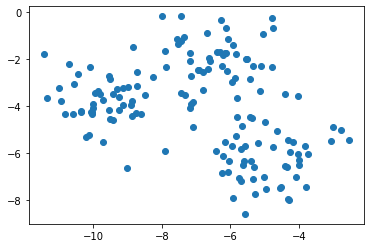

In [24]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150, centers=3, center_box=[-20,5],
                  n_features=2, random_state=0)

import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1])

In [25]:
from sklearn.cluster import KMeans

k= 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

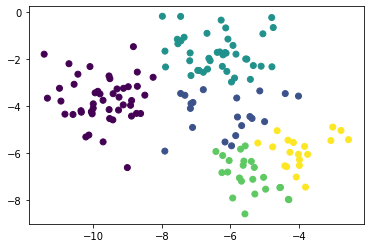

In [37]:
plt.scatter(X[:,0], X[:,1], c=y_pred)

In [38]:
# Functions by Aurelien Geron (GitHub)
import numpy as np

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

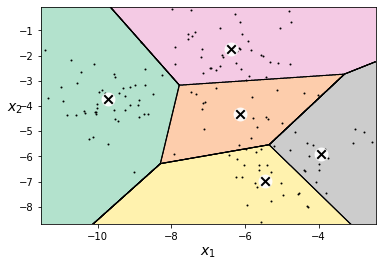

In [36]:
# plot clusters and Voronoi diagriam
plot_decision_boundaries(kmeans, X)

**k: optimal number of clusters:** 

The choice of k determines how good the model is and is thus not an easy decision. One way is to plot the inertia (distance to the centroids) as a function of k and use the elbow method to chose k where the change of slope is most significant. In this case we would use k=3. 

Text(0.5, 1.0, 'Elbow Method: Inertia by k')

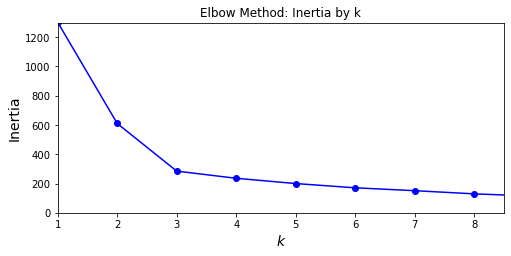

In [53]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 8.5, 0, 1300])
plt.title("Elbow Method: Inertia by k")

Alternatively and more precicely, we can compare **silhouette scores** for different number of clusters. The silhouette score is the mean silhouette coefficient over all instances. The coefficient is high for a instance that is close to the other of the same cluster while having a large distance to those of other clusters. A coefficient of 0 means that the instance is close to a decision boundary. Negative coefficients might hint that the instance has been assigned to the wrong cluster.

Based on the highest silhouette score, we would still decide k to be 3.

Text(0.5, 1.0, 'Silhouette Scores by k')

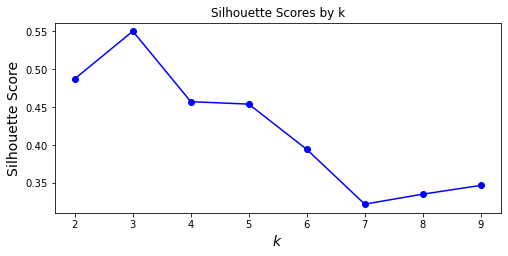

In [57]:
from sklearn.metrics import silhouette_score

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]

silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 10), silhouettes, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.title("Silhouette Scores by k")

Even more informative is the **silhouette diagram** which plots every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. The height shows the number of instances per cluster and the width the sorted silhouette coefficients. The dashed line indicates the mean silhouette coefficient.

What we are looking for is k such that the width of each cluster is as large as possible while being not too different. Again, choice would be k=3.

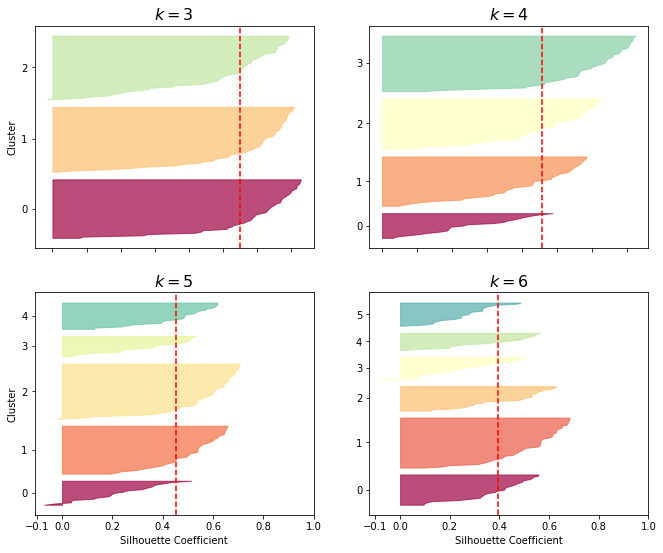

In [61]:
# Code by Aurelien Geron
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


# 2. Clustering for Image Segmentation